In [1]:
import pyforest

In [2]:
sys.path.append(str(Path.cwd().parent.absolute()))

In [3]:
from common.tsfms import get_tsfms
from common.dataset import ColoredMNIST
from networks import MLP, ToyNet, ResNet18

In [4]:
class Extractor:
    def __init__(self, model, names=['layer1.0', 'layer2.0', 'layer3.0', 'aux1', 'aux2', 'aux3', 'fc']):
        self.feats = {}
        self.model = model.eval()

        for name, module in self.model.named_modules():
            if name in names:
                module.register_forward_hook(self.save_output_hook(name))

    def save_output_hook(self, name):
        def func(module, input, output):
            if output.dim() > 2:
                output = F.adaptive_avg_pool2d(output, 1)
                output = output.flatten(1)
            output = output.transpose(0, 1)
            # output = F.normalize(output, dim=-1)
            output = output.cpu().numpy()
            self.feats[name.split('.')[0]] = output
        return func

    def __call__(self, *args, **kwargs):
        self.feats = {}
        with torch.no_grad():
            self.model(*args, **kwargs)
        return self.feats
    
    def to(self, *args, **kwargs):
        self.model = self.model.to(*args, **kwargs)
        return self
    
    def cuda(self, *args, **kwargs):
        self.model = self.model.cuda(*args, **kwargs)
        return self

In [5]:
def select_data(dataset, digits=[], colors=[], seed=42):
    np.random.seed(seed)

    indexs = []
    labels = dataset.targets
    labels = pd.Series([f'{x[0]}{x[1]}' for x in labels])
    maxnum = labels.value_counts().min()

    if digits:
        assert len(digits) == 2
        for d in digits:
            for c in range(10):
                temp = labels[labels == f'{d}{c}'].sample(maxnum, random_state=seed)
                indexs.append(temp)
    elif colors:
        assert len(colors) == 2
        for c in colors:
            for d in range(10):
                temp = labels[labels == f'{d}{c}'].sample(maxnum, random_state=seed)
                indexs.append(temp)
    else:
        raise Exception('`digits` and `colors` cannot both be empty')
        
    indexs = pd.concat(indexs).index.to_numpy()
    indexs = indexs.reshape(2, -1)
    shufle = np.random.permutation(indexs.shape[1])
    indexs = indexs[:, shufle].flatten()
    return indexs

In [6]:
def corrcoef(model, loader, device='cuda'):
    model = model.to(device)
    input = list(loader)[0][0].to(device)
    feats = model(input)

    for key, feat in feats.items():
        temp = []
        for i in range(feat.shape[0]):
            corr = np.corrcoef(feat[i].reshape(2, -1))
            corr = 1 - abs(corr[0, 1])
            temp.append(corr)
        temp = np.array(temp)
        feats[key] = temp
        
    return feats

In [7]:
tsfm = get_tsfms('mnist')[-1]
dataset = ColoredMNIST('../data', train=True, transform=tsfm, skewed=0.9, download=True)

indices = select_data(dataset, digits=[1, 5], seed=42)
dloader = DataLoader(Subset(dataset, indices), batch_size=len(indices))

indices = select_data(dataset, colors=[0, 5], seed=42)
cloader = DataLoader(Subset(dataset, indices), batch_size=len(indices))

Files already downloaded and verified


In [8]:
corrs = {}
feat_dim = 256
# for group in tqdm([8]):
#     for index in tqdm([3], leave=False):
for group in tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256]):
    for index in tqdm([0, 4, 5], leave=False):
        model = ToyNet(num_classes=10, feat_dim=feat_dim)
        model.fc = MLP(model.fc.in_features, model.feat_dim)
        state = torch.load(
            f'../ckpts/mnist.4.{feat_dim}.k{group if index in [3, 4] else 1}'
            f'/mode{index}_skewed0.01_severity1/epoch99.pkl'
        )
        model.load_state_dict(state['model'], strict=True)
        model = Extractor(model)

        shape_corr = corrcoef(model, dloader)
        color_corr = corrcoef(model, cloader)
        corrs_dict = {'shape': shape_corr, 'color': color_corr}
        corrs[f'mode{index}_group{group}'] = corrs_dict
torch.save(corrs, f'../temp/mnist_corrs_{feat_dim}.pkl')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
corrs = torch.load(f'../temp/mnist_corrs_{feat_dim}.pkl')

In [10]:
def plot_corr(modes, name, flags=['.', 'x', '*'], labels=['mode0', 'mode4', 'mode5'], postfix='', lims=None):
    plt.figure()

    if lims is not None:
        plt.xlim(*lims[0])
        plt.ylim(*lims[1])

    for i, corrs in enumerate(modes):
        shape_corr = corrs['shape'][name]
        color_corr = corrs['color'][name]
        plt.plot(shape_corr, color_corr, flags[i])

    plt.xlabel('Shape Correlation')
    plt.ylabel('Color Correlation')
    plt.legend(labels=labels)
    plt.title(f'Correlation of {name}, {postfix}')

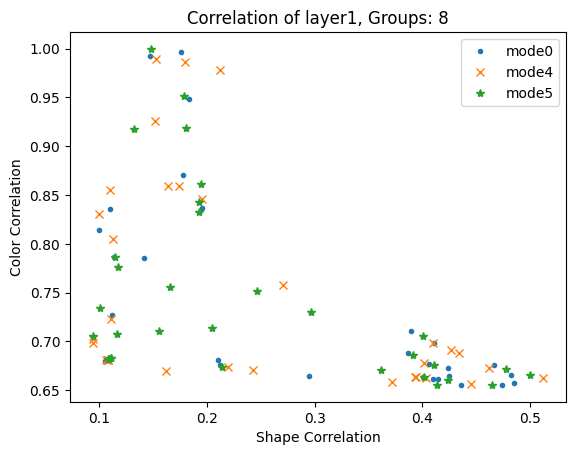

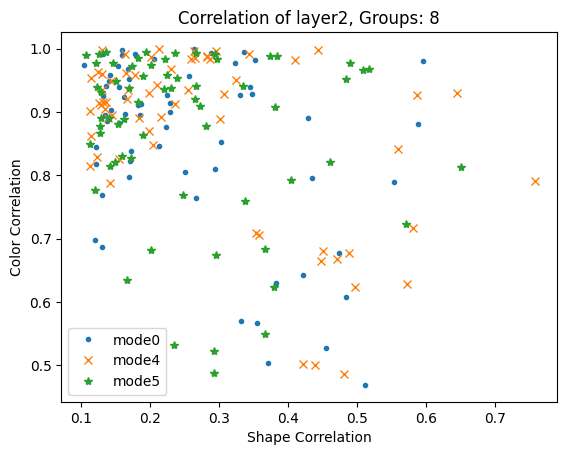

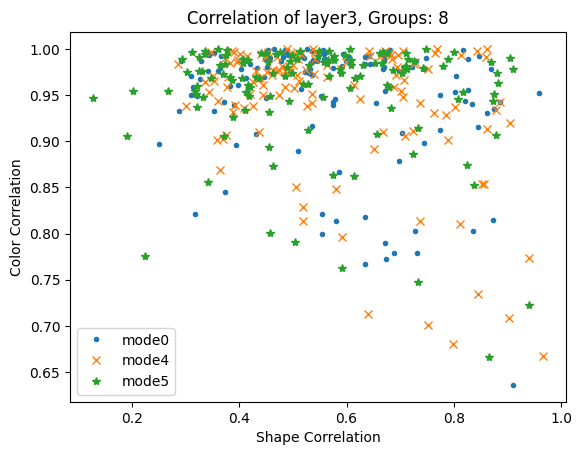

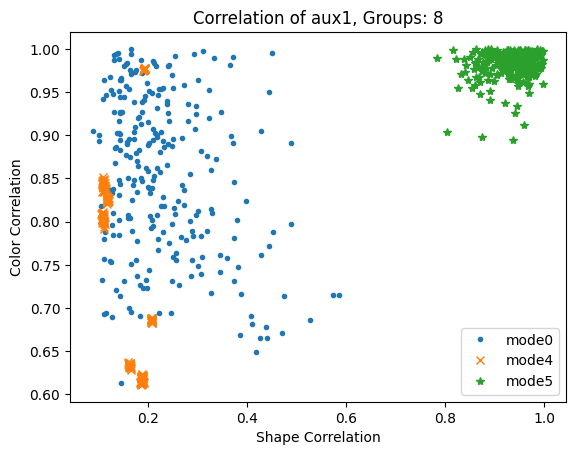

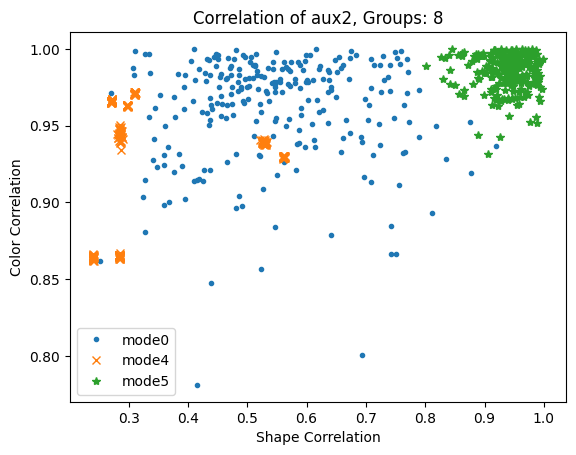

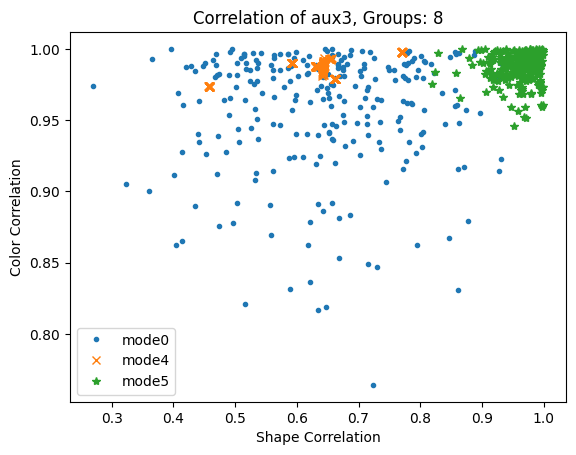

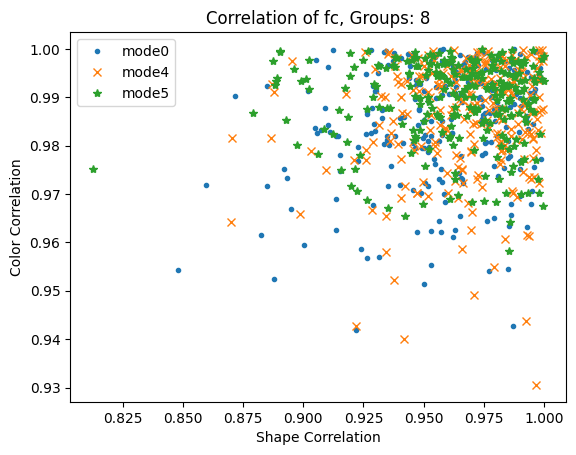

In [11]:
group = 8
modes = [corrs[f'mode{index}_group{group}'] for index in [0, 4, 5]]
names = ['layer1', 'layer2', 'layer3', 'aux1', 'aux2', 'aux3', 'fc']
for name in names:
    plot_corr(modes, name, postfix=f'Groups: {group}', lims=None)